In [1]:
import mne
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import scipy

# Add project root to Python path to import config
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(PROJECT_ROOT)
from src.eeg import config
from src.eeg._11_eeg_preprocessor import EEGProcessor # We'll need this class for its methods

# --- Define a subject and session to visualize ---
SUBJ_ID = 804  # PD subject for this example
SESSION_NUM = 1 
TASK_NAME = "REST"
RAW_FNAME_BASE = f"{SUBJ_ID}_{SESSION_NUM}_PD_{TASK_NAME}"
RAW_FNAME_FULL = os.path.join(config.RAW_EEG_DATA_DIR, f"{RAW_FNAME_BASE}{config.RAW_FNAME_SUFFIX}")

print(f"Visualizing preprocessing for Subject {SUBJ_ID}, Session {SESSION_NUM}")
print(f"Loading raw file: {RAW_FNAME_FULL}")

try:
    # Load the raw data (all channels)
    raw = mne.io.read_raw_fif(RAW_FNAME_FULL, preload=True, verbose=False)
    print("Raw data loaded successfully. Initial state:")
    
    # Let's make a copy for step-by-step processing to easily compare 'before' and 'after'
    raw_for_processing = raw.copy()

except FileNotFoundError:
    print("Error: Raw data file not found. Ensure it has been created by 00_convert_mat_to_fif.py")
    raw = None
    raw_for_processing = None
except Exception as e:
    print(f"An error occurred during raw data loading: {e}")
    raw = None
    raw_for_processing = None

if raw is not None:
    # --- Check initial channel types ---
    print("\nInitial Channel Types:")
    print(raw.get_channel_types())

Visualizing preprocessing for Subject 804, Session 1
Loading raw file: /Users/patriciawatanabe/Projects/Neurotech/NTUT25_Software/data/eeg/raw/804_1_PD_REST-epo.fif
Raw data loaded successfully. Initial state:


/var/folders/lm/g0fsyqm52tjf6q4x94d9mdvw0000gn/T/ipykernel_47091/1900257462.py:26: RuntimeWarning: This filename (/Users/patriciawatanabe/Projects/Neurotech/NTUT25_Software/data/eeg/raw/804_1_PD_REST-epo.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(RAW_FNAME_FULL, preload=True, verbose=False)



Initial Channel Types:
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eog', 'misc', 'misc', 'misc']


Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...

--- Visualizing Filtering & Re-referencing ---
Using qt as 2D backend.
Using pyopengl with version 3.1.9
Using pyopengl with version 3.1.9
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


/opt/anaconda3/envs/pd_tremor/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/opt/anaconda3/envs/pd_tremor/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


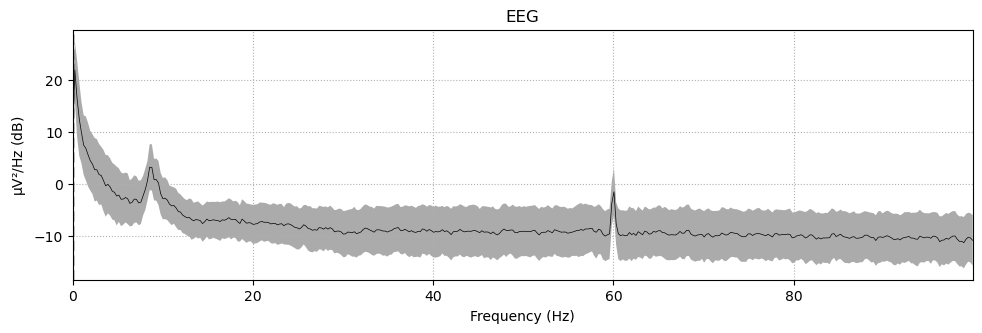

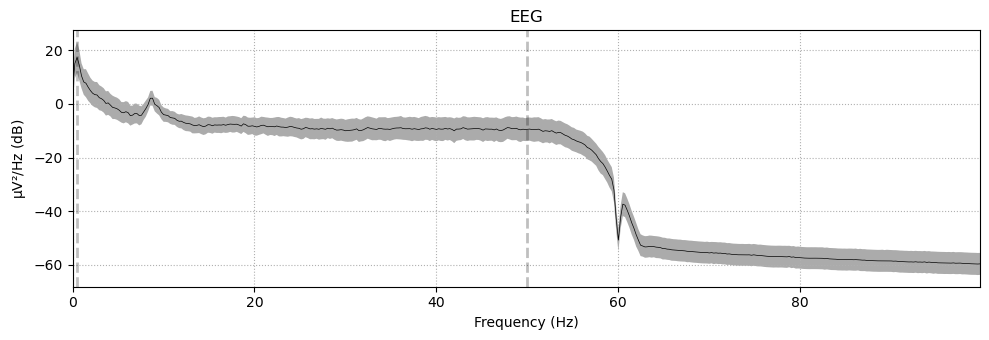

In [2]:
if raw is not None:
    # This is the "before" data, with all channels
    raw_original = raw.copy() 
    
    # This is the "after" data, on which we'll apply the steps
    raw_for_plotting = raw.copy()
    
    # --- Apply Filtering & Re-ref ---
    # Drop misc channels
    misc_ch_names = raw_for_plotting.copy().pick_types(misc=True).ch_names
    if misc_ch_names:
        raw_for_plotting.drop_channels(misc_ch_names)

    # Filtering
    if raw_for_plotting.get_channel_types(picks='eeg'):
        raw_for_plotting.filter(l_freq=config.HIGH_PASS_FREQ, h_freq=config.LOW_PASS_FREQ, 
                   fir_window='hamming', verbose=False)
        if config.LINE_FREQ is not None:
            raw_for_plotting.notch_filter(config.LINE_FREQ, verbose=False)
    
    # Re-referencing
    if raw_for_plotting.get_channel_types(picks='eeg'):
        raw_for_plotting.set_eeg_reference(ref_channels='average', projection=True, verbose=False)
        raw_for_plotting.apply_proj()

    # --- Plotting Before and After ---
    print("\n--- Visualizing Filtering & Re-referencing ---")
    
    # Plot Raw Data (before)
    raw_original.plot(n_channels=67, duration=30, title="Raw Data (before filtering/re-ref)")
    
    # Plot Filtered & Re-referenced Data (after)
    raw_for_plotting.plot(n_channels=raw_for_plotting.info['nchan'], duration=30, title="Data After Filtering & Re-referencing")

    # Plot PSDs separately as they create their own figures
    raw_original.plot_psd(fmax=100, average=True, picks='eeg')
    raw_for_plotting.plot_psd(fmax=100, average=True, picks='eeg')
    
    plt.tight_layout()
    plt.show()

Used Annotations descriptions: ['1', '2', '3', '4', 'boundary']
Bad channels detected: ['Fp1', 'Fp2']

--- Fitting ICA model ---
Fitting ICA to data using 63 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by explained variance: 30 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 3.9s.


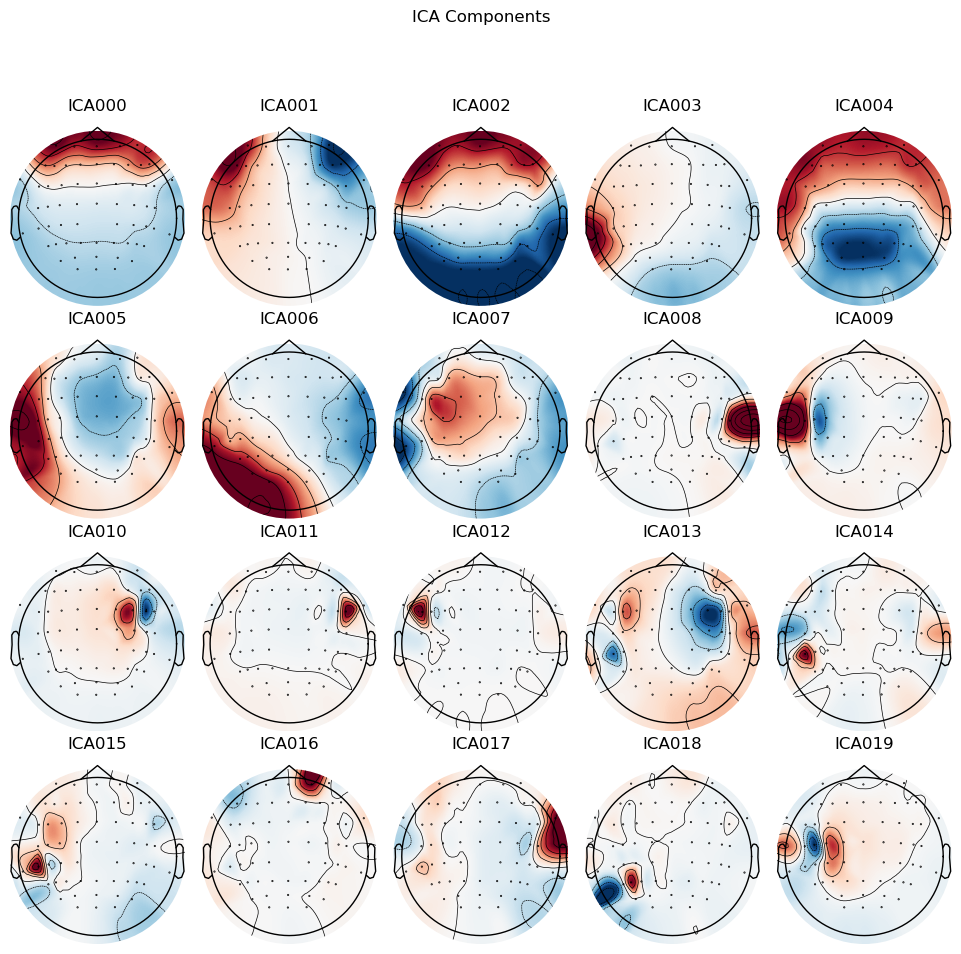

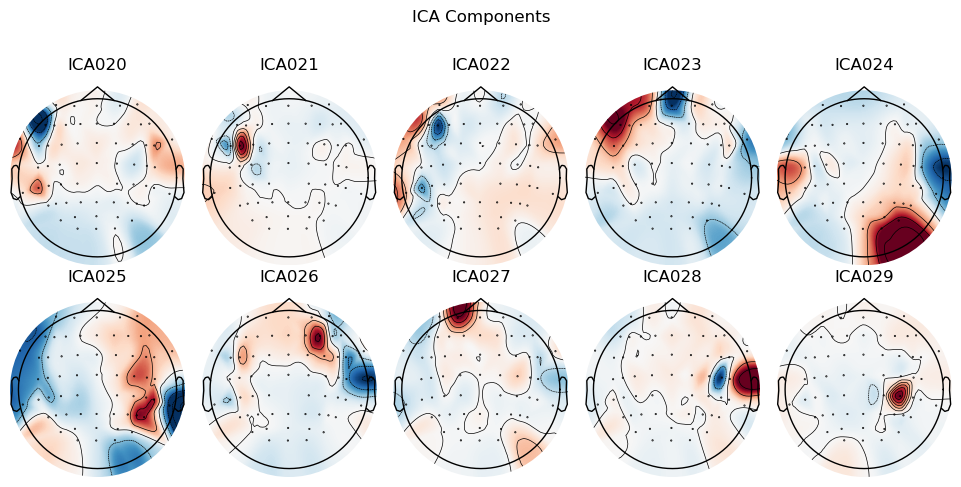

In [6]:
if raw is not None:
    # This code assumes it is running after Cell 2 has been executed.
    # It will use the raw_for_plotting object that was created in the previous cell.

    # --- Segment data before ICA ---
    events, event_id = mne.events_from_annotations(raw_for_plotting, event_id=config.EVENT_ID)
    epochs_before_ica = mne.Epochs(raw_for_plotting, events, event_id=event_id, tmin=0, tmax=3.0,
                                   baseline=None, preload=True, verbose=False)
    
    # --- Automated Bad Channel Detection ---
    eeg_ch_names = epochs_before_ica.copy().pick_types(eeg=True, exclude='bads').ch_names
    temp_epochs_for_bad_ch_detection = epochs_before_ica.copy().pick_types(eeg=True, exclude='bads')
    channel_stds = np.std(temp_epochs_for_bad_ch_detection.get_data(), axis=(0, 2))
    
    channel_stds_z = np.abs(scipy.stats.zscore(channel_stds))
    noisy_ch_indices = np.where(channel_stds_z > config.BAD_CH_NOISY_Z_THRESHOLD)[0]
    bad_channels_found = [eeg_ch_names[i] for i in noisy_ch_indices]
    
    if bad_channels_found:
        print(f"Bad channels detected: {bad_channels_found}")
        raw_for_plotting.info['bads'] = bad_channels_found
        raw_for_plotting.interpolate_bads(reset_bads=False, verbose=False)
    else:
        print("No bad channels detected.")

    # --- Fit ICA model on the continuous data ---
    print("\n--- Fitting ICA model ---")
    ica = mne.preprocessing.ICA(n_components=config.ICA_N_COMPONENTS, method=config.ICA_METHOD,
                                random_state=config.ICA_RANDOM_STATE, max_iter='auto', verbose=False)
    ica.fit(raw_for_plotting, picks=eeg_ch_names)
    
    # --- Plot ICA components for visual inspection ---
    ica.plot_components(title="ICA Components")
    plt.show()

In [11]:
import mne
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from mne.annotations import Annotations

# --- Set up Project Root and Paths ---
# This notebook is in 'notebooks/', so we go up one level to 'NTUT25_SOFTWARE'
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(PROJECT_ROOT)
from src.eeg import config

# --- Define a subject and session to visualize ---
SUBJ_ID = 804  # PD subject for this example
SESSION_NUM = 1 
TASK_NAME = "REST"
RAW_FNAME_BASE = f"{SUBJ_ID}_{SESSION_NUM}_PD_{TASK_NAME}"
RAW_FNAME_FULL = os.path.join(config.RAW_EEG_DATA_DIR, f"{RAW_FNAME_BASE}{config.RAW_FNAME_SUFFIX}")

print(f"Running full preprocessing pipeline to create data for visualization...")

try:
    # --- Step 1: Load and Pre-process the Raw Data ---
    raw_for_processing = mne.io.read_raw_fif(RAW_FNAME_FULL, preload=True, verbose=False)
    
    # Drop misc channels
    misc_ch_names = raw_for_processing.copy().pick_types(misc=True).ch_names
    if misc_ch_names:
        raw_for_processing.drop_channels(misc_ch_names)

    # Filtering
    raw_for_processing.filter(l_freq=config.HIGH_PASS_FREQ, h_freq=config.LOW_PASS_FREQ, 
                               fir_window='hamming', verbose=False)
    if config.LINE_FREQ is not None:
        raw_for_processing.notch_filter(config.LINE_FREQ, verbose=False)
    
    # Re-referencing
    if raw_for_processing.get_channel_types(picks='eeg'):
        raw_for_processing.set_eeg_reference(ref_channels='average', projection=True, verbose=False)
        raw_for_processing.apply_proj()

    # --- Step 2: Segment and Epoch ---
    events, event_id = mne.events_from_annotations(raw_for_processing, event_id=config.EVENT_ID)
    epochs_before_ica = mne.Epochs(raw_for_processing, events, event_id=event_id, tmin=0, tmax=3.0,
                                   baseline=None, preload=True, verbose=False)

    # --- Step 3: ICA for Artifact Removal ---
    eeg_ch_names = epochs_before_ica.copy().pick_types(eeg=True, exclude='bads').ch_names
    ica = mne.preprocessing.ICA(n_components=config.ICA_N_COMPONENTS, method=config.ICA_METHOD,
                                random_state=config.ICA_RANDOM_STATE, max_iter='auto', verbose=False)
    raw_for_ica_fit = raw_for_processing.copy().filter(l_freq=config.ICA_HIGH_PASS_FREQ, h_freq=None, verbose=False)
    ica.fit(raw_for_ica_fit, picks=eeg_ch_names)
    
    eog_indices = []
    if config.VEOG_CHANNEL_NAME in raw_for_processing.ch_names:
        eog_indices, scores = ica.find_bads_eog(raw_for_processing, ch_name=config.VEOG_CHANNEL_NAME, measure='correlation', threshold='auto', verbose=False)
    
    # --- Step 4: Apply ICA and create the final cleaned epochs object ---
    epochs_cleaned = epochs_before_ica.copy()
    if eog_indices:
        ica.apply(epochs_cleaned, exclude=eog_indices)
    
    print("Preprocessing complete. Data is ready for visualization.")
    
    
    # --- VISUALIZATION CODE STARTS HERE ---
    print("\n--- Plotting: Final Cleaned EEG Data ---")
    
    epochs_final_eeg_only = epochs_cleaned.copy().pick_types(eeg=True)
    
    epochs_final_eeg_only.plot(
        n_epochs=5,
        n_channels=epochs_final_eeg_only.info['nchan'],
        scalings=dict(eeg=40e-6),
        title=f"Final Cleaned EEG Data (First 5 Epochs)"
    )
    plt.show()

    epochs_data_concat = np.concatenate(epochs_final_eeg_only.get_data()[:10], axis=1)
    info_temp = epochs_final_eeg_only.info.copy()
    raw_temp = mne.io.RawArray(epochs_data_concat, info_temp, verbose=False)
    
    raw_temp.plot(
        n_channels=info_temp['nchan'], 
        duration=30,
        scalings=dict(eeg=40e-6),
        title="Concatenated Cleaned Epochs"
    )
    plt.show()

except FileNotFoundError:
    print("Error: Raw data file not found. Ensure it has been created.")
except Exception as e:
    print(f"An error occurred during visualization: {e}")
    import traceback
    traceback.print_exc()

Running full preprocessing pipeline to create data for visualization...


/var/folders/lm/g0fsyqm52tjf6q4x94d9mdvw0000gn/T/ipykernel_47091/2270886506.py:25: RuntimeWarning: This filename (/Users/patriciawatanabe/Projects/Neurotech/NTUT25_Software/data/eeg/raw/804_1_PD_REST-epo.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_for_processing = mne.io.read_raw_fif(RAW_FNAME_FULL, preload=True, verbose=False)


Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['1', '2', '3', '4', 'boundary']
Fitting ICA to data using 63 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by explained variance: 32 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 4.8s.
Preprocessing complete. Data is ready for visualization.

--- Plotting: Final Cleaned EEG Data ---
Using pyopengl with version 3.1.9
Using pyopengl with version 3.1.9


In [ ]:
if 'epochs_cleaned' in locals():
    # Final step: Visualize the cleaned EEG data after all preprocessing
    print("\n--- Plotting: Final Cleaned EEG Data ---")
    
    # First, let's create a final epochs object with only the EEG channels,
    # just as your main script would do.
    epochs_final_eeg_only = epochs_cleaned.copy().pick_types(eeg=True)
    
    # Plot the first few epochs to see the effect of all processing.
    # The `scalings` parameter will help prevent clipping.
    epochs_final_eeg_only.plot(
        n_epochs=5,
        n_channels=epochs_final_eeg_only.info['nchan'],
        scalings=dict(eeg=40e-6),  # Adjust scaling as needed for visibility
        title=f"Final Cleaned EEG Data (First 5 Epochs)"
    )
    plt.show()

    # You can also plot a single long segment of the cleaned epochs
    # to get a feel for the continuous nature of the data.
    # We will concatenate the first 10 epochs for this.
    epochs_data_concat = np.concatenate(epochs_final_eeg_only.get_data()[:10], axis=1)
    
    # We can create a temporary raw object to plot this concatenated data
    info_temp = epochs_final_eeg_only.info.copy()
    raw_temp = mne.io.RawArray(epochs_data_concat, info_temp, verbose=False)
    
    raw_temp.plot(
        n_channels=info_temp['nchan'], 
        duration=30, # Plot a 30-second segment
        scalings=dict(eeg=40e-6),
        title="Concatenated Cleaned Epochs"
    )
    plt.show()


--- Plotting: Final Cleaned EEG Data ---
Using pyopengl with version 3.1.9
Using pyopengl with version 3.1.9


Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Channels marked as bad:
['C1']
Channels marked as bad:
none
Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [8]:
# Add project root to Python path to import config
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(PROJECT_ROOT)
from src.eeg import config

# --- Define a subject and session to inspect ---
SUBJ_ID = 804 
SESSION_NUM = 1 
TASK_NAME = "REST"

PROCESSED_FNAME_BASE = f"{SUBJ_ID}_{SESSION_NUM}_PD_{TASK_NAME}_processed"
PROCESSED_FNAME_FULL = os.path.join(config.PROCESSED_EEG_DATA_DIR, f"{PROCESSED_FNAME_BASE}{config.RAW_FNAME_SUFFIX}")

print(f"Loading processed epochs from: {PROCESSED_FNAME_FULL}")

try:
    epochs = mne.read_epochs(PROCESSED_FNAME_FULL, preload=True, verbose=False)

    print("\n--- Epoch Labels ---")
    # The `events` attribute is a NumPy array, where the last column is the event ID
    print(f"Event IDs in the epochs object: {np.unique(epochs.events[:, 2])}")
    
    # The `event_id` attribute is a dictionary mapping these IDs to labels
    print(f"Label mapping: {epochs.event_id}")
    
    # You can also print the number of epochs for each label
    print(f"Number of 'Eyes_Open' epochs: {len(epochs['Eyes_Open'])}")
    print(f"Number of 'Eyes_Closed' epochs: {len(epochs['Eyes_Closed'])}")

except FileNotFoundError:
    print(f"Error: Processed file not found at {PROCESSED_FNAME_FULL}.")

Loading processed epochs from: /Users/patriciawatanabe/Projects/Neurotech/NTUT25_Software/data/eeg/processed/804_1_PD_REST_processed-epo.fif

--- Epoch Labels ---
Event IDs in the epochs object: [100 200]
Label mapping: {'Eyes_Open': 100, 'Eyes_Closed': 200}
Number of 'Eyes_Open' epochs: 20
Number of 'Eyes_Closed' epochs: 20


In [2]:
import mne
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import scipy

# Add project root to Python path to import config
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(PROJECT_ROOT)
from src.eeg import config
from src.eeg._11_eeg_preprocessor import EEGProcessor # We'll need this class for its methods

# --- Define a subject and session to visualize ---
SUBJ_ID = 801  # PD subject for this example
SESSION_NUM = 1 
TASK_NAME = "REST"
RAW_FNAME_BASE = f"{SUBJ_ID}_{SESSION_NUM}_PD_{TASK_NAME}"
RAW_FNAME_FULL = os.path.join(config.RAW_EEG_DATA_DIR, f"{RAW_FNAME_BASE}{config.RAW_FNAME_SUFFIX}")

print(f"Visualizing preprocessing for Subject {SUBJ_ID}, Session {SESSION_NUM}")
print(f"Loading raw file: {RAW_FNAME_FULL}")

try:
    # Load the raw data (all channels)
    raw = mne.io.read_raw_fif(RAW_FNAME_FULL, preload=True, verbose=False)
    print("Raw data loaded successfully. Initial state:")
    
    # Let's make a copy for step-by-step processing to easily compare 'before' and 'after'
    raw_for_processing = raw.copy()

except FileNotFoundError:
    print("Error: Raw data file not found. Ensure it has been created by 00_convert_mat_to_fif.py")
    raw = None
    raw_for_processing = None
except Exception as e:
    print(f"An error occurred during raw data loading: {e}")
    raw = None
    raw_for_processing = None

if raw is not None:
    # --- Check initial channel types ---
    print("\nInitial Channel Types:")
    print(raw.get_channel_types())

Visualizing preprocessing for Subject 801, Session 1
Loading raw file: /Users/patriciawatanabe/Projects/Neurotech/NTUT25_Software/data/eeg/raw/801_1_PD_REST-epo.fif
Error: Raw data file not found. Ensure it has been created by 00_convert_mat_to_fif.py


/var/folders/lm/g0fsyqm52tjf6q4x94d9mdvw0000gn/T/ipykernel_3411/603538265.py:26: RuntimeWarning: This filename (/Users/patriciawatanabe/Projects/Neurotech/NTUT25_Software/data/eeg/raw/801_1_PD_REST-epo.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(RAW_FNAME_FULL, preload=True, verbose=False)


In [3]:
if raw is not None:
    # This is the "before" data, with all channels
    raw_original = raw.copy() 
    
    # This is the "after" data, on which we'll apply the steps
    raw_for_plotting = raw.copy()
    
    # --- Apply Filtering & Re-ref ---
    # Drop misc channels
    misc_ch_names = raw_for_plotting.copy().pick_types(misc=True).ch_names
    if misc_ch_names:
        raw_for_plotting.drop_channels(misc_ch_names)

    # Filtering
    if raw_for_plotting.get_channel_types(picks='eeg'):
        raw_for_plotting.filter(l_freq=config.HIGH_PASS_FREQ, h_freq=config.LOW_PASS_FREQ, 
                   fir_window='hamming', verbose=False)
        if config.LINE_FREQ is not None:
            raw_for_plotting.notch_filter(config.LINE_FREQ, verbose=False)
    
    # Re-referencing
    if raw_for_plotting.get_channel_types(picks='eeg'):
        raw_for_plotting.set_eeg_reference(ref_channels='average', projection=True, verbose=False)
        raw_for_plotting.apply_proj()

    # --- Plotting Before and After ---
    print("\n--- Visualizing Filtering & Re-referencing ---")
    
    # Plot Raw Data (before)
    raw_original.plot(n_channels=67, duration=30, title="Raw Data (before filtering/re-ref)")
    
    # Plot Filtered & Re-referenced Data (after)
    raw_for_plotting.plot(n_channels=raw_for_plotting.info['nchan'], duration=30, title="Data After Filtering & Re-referencing")

    # Plot PSDs separately as they create their own figures
    raw_original.plot_psd(fmax=100, average=True, picks='eeg')
    raw_for_plotting.plot_psd(fmax=100, average=True, picks='eeg')
    
    plt.tight_layout()
    plt.show()

In [4]:
if raw is not None:
    # This code assumes it is running after Cell 2 has been executed.
    # It will use the raw_for_plotting object that was created in the previous cell.

    # --- Segment data before ICA ---
    events, event_id = mne.events_from_annotations(raw_for_plotting, event_id=config.EVENT_ID)
    epochs_before_ica = mne.Epochs(raw_for_plotting, events, event_id=event_id, tmin=0, tmax=3.0,
                                   baseline=None, preload=True, verbose=False)
    
    # --- Automated Bad Channel Detection ---
    eeg_ch_names = epochs_before_ica.copy().pick_types(eeg=True, exclude='bads').ch_names
    temp_epochs_for_bad_ch_detection = epochs_before_ica.copy().pick_types(eeg=True, exclude='bads')
    channel_stds = np.std(temp_epochs_for_bad_ch_detection.get_data(), axis=(0, 2))
    
    channel_stds_z = np.abs(scipy.stats.zscore(channel_stds))
    noisy_ch_indices = np.where(channel_stds_z > config.BAD_CH_NOISY_Z_THRESHOLD)[0]
    bad_channels_found = [eeg_ch_names[i] for i in noisy_ch_indices]
    
    if bad_channels_found:
        print(f"Bad channels detected: {bad_channels_found}")
        raw_for_plotting.info['bads'] = bad_channels_found
        raw_for_plotting.interpolate_bads(reset_bads=False, verbose=False)
    else:
        print("No bad channels detected.")

    # --- Fit ICA model on the continuous data ---
    print("\n--- Fitting ICA model ---")
    ica = mne.preprocessing.ICA(n_components=config.ICA_N_COMPONENTS, method=config.ICA_METHOD,
                                random_state=config.ICA_RANDOM_STATE, max_iter='auto', verbose=False)
    ica.fit(raw_for_plotting, picks=eeg_ch_names)
    
    # --- Plot ICA components for visual inspection ---
    ica.plot_components(title="ICA Components")
    plt.show()

In [5]:
import mne
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from mne.annotations import Annotations

# --- Set up Project Root and Paths ---
# This notebook is in 'notebooks/', so we go up one level to 'NTUT25_SOFTWARE'
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(PROJECT_ROOT)
from src.eeg import config

# --- Define a subject and session to visualize ---
SUBJ_ID = 804  # PD subject for this example
SESSION_NUM = 1 
TASK_NAME = "REST"
RAW_FNAME_BASE = f"{SUBJ_ID}_{SESSION_NUM}_PD_{TASK_NAME}"
RAW_FNAME_FULL = os.path.join(config.RAW_EEG_DATA_DIR, f"{RAW_FNAME_BASE}{config.RAW_FNAME_SUFFIX}")

print(f"Running full preprocessing pipeline to create data for visualization...")

try:
    # --- Step 1: Load and Pre-process the Raw Data ---
    raw_for_processing = mne.io.read_raw_fif(RAW_FNAME_FULL, preload=True, verbose=False)
    
    # Drop misc channels
    misc_ch_names = raw_for_processing.copy().pick_types(misc=True).ch_names
    if misc_ch_names:
        raw_for_processing.drop_channels(misc_ch_names)

    # Filtering
    raw_for_processing.filter(l_freq=config.HIGH_PASS_FREQ, h_freq=config.LOW_PASS_FREQ, 
                               fir_window='hamming', verbose=False)
    if config.LINE_FREQ is not None:
        raw_for_processing.notch_filter(config.LINE_FREQ, verbose=False)
    
    # Re-referencing
    if raw_for_processing.get_channel_types(picks='eeg'):
        raw_for_processing.set_eeg_reference(ref_channels='average', projection=True, verbose=False)
        raw_for_processing.apply_proj()

    # --- Step 2: Segment and Epoch ---
    events, event_id = mne.events_from_annotations(raw_for_processing, event_id=config.EVENT_ID)
    epochs_before_ica = mne.Epochs(raw_for_processing, events, event_id=event_id, tmin=0, tmax=3.0,
                                   baseline=None, preload=True, verbose=False)

    # --- Step 3: ICA for Artifact Removal ---
    eeg_ch_names = epochs_before_ica.copy().pick_types(eeg=True, exclude='bads').ch_names
    ica = mne.preprocessing.ICA(n_components=config.ICA_N_COMPONENTS, method=config.ICA_METHOD,
                                random_state=config.ICA_RANDOM_STATE, max_iter='auto', verbose=False)
    raw_for_ica_fit = raw_for_processing.copy().filter(l_freq=config.ICA_HIGH_PASS_FREQ, h_freq=None, verbose=False)
    ica.fit(raw_for_ica_fit, picks=eeg_ch_names)
    
    eog_indices = []
    if config.VEOG_CHANNEL_NAME in raw_for_processing.ch_names:
        eog_indices, scores = ica.find_bads_eog(raw_for_processing, ch_name=config.VEOG_CHANNEL_NAME, measure='correlation', threshold='auto', verbose=False)
    
    # --- Step 4: Apply ICA and create the final cleaned epochs object ---
    epochs_cleaned = epochs_before_ica.copy()
    if eog_indices:
        ica.apply(epochs_cleaned, exclude=eog_indices)
    
    print("Preprocessing complete. Data is ready for visualization.")
    
    
    # --- VISUALIZATION CODE STARTS HERE ---
    print("\n--- Plotting: Final Cleaned EEG Data ---")
    
    epochs_final_eeg_only = epochs_cleaned.copy().pick_types(eeg=True)
    
    epochs_final_eeg_only.plot(
        n_epochs=5,
        n_channels=epochs_final_eeg_only.info['nchan'],
        scalings=dict(eeg=40e-6),
        title=f"Final Cleaned EEG Data (First 5 Epochs)"
    )
    plt.show()

    epochs_data_concat = np.concatenate(epochs_final_eeg_only.get_data()[:10], axis=1)
    info_temp = epochs_final_eeg_only.info.copy()
    raw_temp = mne.io.RawArray(epochs_data_concat, info_temp, verbose=False)
    
    raw_temp.plot(
        n_channels=info_temp['nchan'], 
        duration=30,
        scalings=dict(eeg=40e-6),
        title="Concatenated Cleaned Epochs"
    )
    plt.show()

except FileNotFoundError:
    print("Error: Raw data file not found. Ensure it has been created.")
except Exception as e:
    print(f"An error occurred during visualization: {e}")
    import traceback
    traceback.print_exc()

Running full preprocessing pipeline to create data for visualization...


/var/folders/lm/g0fsyqm52tjf6q4x94d9mdvw0000gn/T/ipykernel_3411/2270886506.py:25: RuntimeWarning: This filename (/Users/patriciawatanabe/Projects/Neurotech/NTUT25_Software/data/eeg/raw/804_1_PD_REST-epo.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_for_processing = mne.io.read_raw_fif(RAW_FNAME_FULL, preload=True, verbose=False)


Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['1', '2', '3', '4', 'boundary']
Fitting ICA to data using 63 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by explained variance: 32 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 4.4s.
Preprocessing complete. Data is ready for visualization.

--- Plotting: Final Cleaned EEG Data ---
Using qt as 2D backend.
Using pyopengl with version 3.1.9
Using pyopengl with version 3.1.9


In [6]:
if 'epochs_cleaned' in locals():
    # Final step: Visualize the cleaned EEG data after all preprocessing
    print("\n--- Plotting: Final Cleaned EEG Data ---")
    
    # First, let's create a final epochs object with only the EEG channels,
    # just as your main script would do.
    epochs_final_eeg_only = epochs_cleaned.copy().pick_types(eeg=True)
    
    # Plot the first few epochs to see the effect of all processing.
    # The `scalings` parameter will help prevent clipping.
    epochs_final_eeg_only.plot(
        n_epochs=5,
        n_channels=epochs_final_eeg_only.info['nchan'],
        scalings=dict(eeg=40e-6),  # Adjust scaling as needed for visibility
        title=f"Final Cleaned EEG Data (First 5 Epochs)"
    )
    plt.show()

    # You can also plot a single long segment of the cleaned epochs
    # to get a feel for the continuous nature of the data.
    # We will concatenate the first 10 epochs for this.
    epochs_data_concat = np.concatenate(epochs_final_eeg_only.get_data()[:10], axis=1)
    
    # We can create a temporary raw object to plot this concatenated data
    info_temp = epochs_final_eeg_only.info.copy()
    raw_temp = mne.io.RawArray(epochs_data_concat, info_temp, verbose=False)
    
    raw_temp.plot(
        n_channels=info_temp['nchan'], 
        duration=30, # Plot a 30-second segment
        scalings=dict(eeg=40e-6),
        title="Concatenated Cleaned Epochs"
    )
    plt.show()


--- Plotting: Final Cleaned EEG Data ---
Using pyopengl with version 3.1.9
Using pyopengl with version 3.1.9


In [7]:
# Add project root to Python path to import config
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(PROJECT_ROOT)
from src.eeg import config

# --- Define a subject and session to inspect ---
SUBJ_ID = 801 
SESSION_NUM = 1 
TASK_NAME = "REST"

PROCESSED_FNAME_BASE = f"{SUBJ_ID}_{SESSION_NUM}_PD_{TASK_NAME}_processed"
PROCESSED_FNAME_FULL = os.path.join(config.PROCESSED_EEG_DATA_DIR, f"{PROCESSED_FNAME_BASE}{config.RAW_FNAME_SUFFIX}")

print(f"Loading processed epochs from: {PROCESSED_FNAME_FULL}")

try:
    epochs = mne.read_epochs(PROCESSED_FNAME_FULL, preload=True, verbose=False)

    print("\n--- Epoch Labels ---")
    # The `events` attribute is a NumPy array, where the last column is the event ID
    print(f"Event IDs in the epochs object: {np.unique(epochs.events[:, 2])}")
    
    # The `event_id` attribute is a dictionary mapping these IDs to labels
    print(f"Label mapping: {epochs.event_id}")
    
    # You can also print the number of epochs for each label
    print(f"Number of 'Eyes_Open' epochs: {len(epochs['Eyes_Open'])}")
    print(f"Number of 'Eyes_Closed' epochs: {len(epochs['Eyes_Closed'])}")

except FileNotFoundError:
    print(f"Error: Processed file not found at {PROCESSED_FNAME_FULL}.")

Loading processed epochs from: /Users/patriciawatanabe/Projects/Neurotech/NTUT25_Software/data/eeg/processed/801_1_PD_REST_processed-epo.fif
Error: Processed file not found at /Users/patriciawatanabe/Projects/Neurotech/NTUT25_Software/data/eeg/processed/801_1_PD_REST_processed-epo.fif.


Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
